# Import libraries

In [1]:
!pip install --upgrade pip setuptools
!pip install wordcloud
# !pip install lightgbm
!pip install nltk
!pip install imbalanced-learn
!pip install --upgrade scikit-learn
!pip install --upgrade imbalanced-learn
!pip install -U Textblob
!python -m textblob.download_corpora
!pip install unidecode
# !pip install lightgbm==2.2.3
!pip install contractions
!pip install scikit-optimize
!pip install scipy

[nltk_data] Downloading package brown to
[nltk_data]     /Users/sebastianhaecker/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/sebastianhaecker/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/sebastianhaecker/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/sebastianhaecker/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package conll2000 to
[nltk_data]     /Users/sebastianhaecker/nltk_data...
[nltk_data]   Package conll2000 is already up-to-date!
[nltk_data] Downloading package movie_reviews to
[nltk_data]     /Users/sebastianhaecker/nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!
Finished.


In [3]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# import modules
# packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import seaborn as sns
import nltk
import re
import joblib
import contractions
import scipy.stats

# modules preprocessing
from matplotlib.ticker import FormatStrFormatter 
from matplotlib.colors import LinearSegmentedColormap
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
from wordcloud import WordCloud
from collections import Counter
from unidecode import unidecode
from nltk.corpus import stopwords
nltk.download('wordnet')
nltk.download('punkt')
import contractions
from scipy.stats import randint, uniform

# sentiment & transforming features
from textblob import TextBlob
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.under_sampling import RandomUnderSampler

# algorithms
from sklearn.ensemble import RandomForestClassifier
# import lightgbm as lgb
from sklearn.svm import SVC

# evaluation
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, mean_absolute_error,  mean_squared_error
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/sebastianhaecker/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/sebastianhaecker/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/sebastianhaecker/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Load clean data

In [12]:
df = pd.read_csv('clean_data.csv', index_col=0)
# df = pd.read_csv('/content/drive/MyDrive/3_classes/clean_data.csv', index_col=0)  # running lightgbm in colab

In [13]:
# Split data in train and test
train, test = train_test_split(df, test_size=0.1, random_state=42, stratify=df['EaseofUse'])

In [14]:
print(train.info())
print(test.info())

<class 'pandas.core.frame.DataFrame'>
Index: 68211 entries, 233007 to 200930
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Age        68211 non-null  object
 1   Reviews    68211 non-null  object
 2   Sex        68211 non-null  object
 3   EaseofUse  68211 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 2.6+ MB
None
<class 'pandas.core.frame.DataFrame'>
Index: 7579 entries, 211222 to 44054
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Age        7579 non-null   object
 1   Reviews    7579 non-null   object
 2   Sex        7579 non-null   object
 3   EaseofUse  7579 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 296.1+ KB
None


## Undersample train set

In [15]:
# Class imbalance Undersampling the data distribution with RandomUnderSampler
X_train = train.drop(columns=['EaseofUse'])
y_train = train['EaseofUse']
rus = RandomUnderSampler(sampling_strategy='not minority', random_state=42)
X_train_resampled, y_train_resampled = rus.fit_resample(X_train, y_train)

train = pd.DataFrame(X_train_resampled, columns=X_train.columns)
train['EaseofUse'] = y_train_resampled
print(train.EaseofUse.value_counts())

EaseofUse
1    7422
2    7422
3    7422
Name: count, dtype: int64


In [16]:
print(train.info())
print(test.info())

<class 'pandas.core.frame.DataFrame'>
Index: 22266 entries, 183081 to 193215
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Age        22266 non-null  object
 1   Reviews    22266 non-null  object
 2   Sex        22266 non-null  object
 3   EaseofUse  22266 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 869.8+ KB
None
<class 'pandas.core.frame.DataFrame'>
Index: 7579 entries, 211222 to 44054
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Age        7579 non-null   object
 1   Reviews    7579 non-null   object
 2   Sex        7579 non-null   object
 3   EaseofUse  7579 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 296.1+ KB
None


### Transform features

In [17]:
# Encode categorical features with dummies encoding en label encoding RUN ONLY WHEN TESTING WITH FEATURES FROM DATASET
train = pd.get_dummies(train, columns=['Sex'])
test = pd.get_dummies(test, columns=['Sex'])

ordinal_encoder = OrdinalEncoder()
train['Age'] = ordinal_encoder.fit_transform(train[['Age']])
test['Age'] = ordinal_encoder.transform(test[['Age']])

In [9]:
print(train.info())
print(test.info())

<class 'pandas.core.frame.DataFrame'>
Index: 22266 entries, 183081 to 193215
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Age         22266 non-null  float64
 1   Reviews     22266 non-null  object 
 2   EaseofUse   22266 non-null  int64  
 3   Sex_Female  22266 non-null  bool   
 4   Sex_Male    22266 non-null  bool   
dtypes: bool(2), float64(1), int64(1), object(1)
memory usage: 739.3+ KB
None
<class 'pandas.core.frame.DataFrame'>
Index: 7579 entries, 211222 to 44054
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Age         7579 non-null   float64
 1   Reviews     7579 non-null   object 
 2   EaseofUse   7579 non-null   int64  
 3   Sex_Female  7579 non-null   bool   
 4   Sex_Male    7579 non-null   bool   
dtypes: bool(2), float64(1), int64(1), object(1)
memory usage: 251.6+ KB
None


In [18]:
# Apply TF-IDF and ngrams on the review fature to be processed, CHANGE SETTING WHEN RUNNING UNIGRAMS, BIGRAMS OR TOGHETHER 
tfidf_vectorizer = TfidfVectorizer(use_idf= True,smooth_idf = False, min_df= 0.005) #default
# tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,1),smooth_idf = False, min_df= 0.005) #unigrams 
# tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,2), use_idf= True,smooth_idf = False, min_df= 0.005) #unigrams and bigrams

# Transform reviews
tfidf_train = tfidf_vectorizer.fit_transform(train['Reviews'])
tfidf_test = tfidf_vectorizer.transform(test['Reviews'])

# Convert to dataframe
X_train_text = pd.DataFrame(tfidf_train.toarray(), columns=tfidf_vectorizer.get_feature_names_out(), index=train.index)
X_test_text = pd.DataFrame(tfidf_test.toarray(), columns=tfidf_vectorizer.get_feature_names_out(), index=test.index)

# Concatenate and make dataframe
train = pd.concat([train.drop(columns='Reviews'), X_train_text], axis=1)
test = pd.concat([test.drop(columns='Reviews'), X_test_text], axis=1)

In [19]:
print (train.shape)
print (test.shape)

(22266, 932)
(7579, 932)


In [20]:
# Split the train and test set for prediction in: X_train, y_train, X_test, y_test
X_train = train.drop(columns=['EaseofUse'])
y_train = train['EaseofUse']
X_test = test.drop(columns=['EaseofUse'])
y_test = test['EaseofUse']

In [21]:
print (X_train.shape)
print (y_train.shape)
print (X_test.shape)
print (y_test.shape)

(22266, 931)
(22266,)
(7579, 931)
(7579,)


# Baseline 

## Random Forests 

In [1130]:
# Baseline Random Forests with undersampling
rf_under = RandomForestClassifier(random_state = 42)
rf_under.fit(X_train, y_train)
y_pred = rf_under.predict(X_test)

Test MAE: 0.661
Test RMSE: 1.024
Test CWK: 0.284



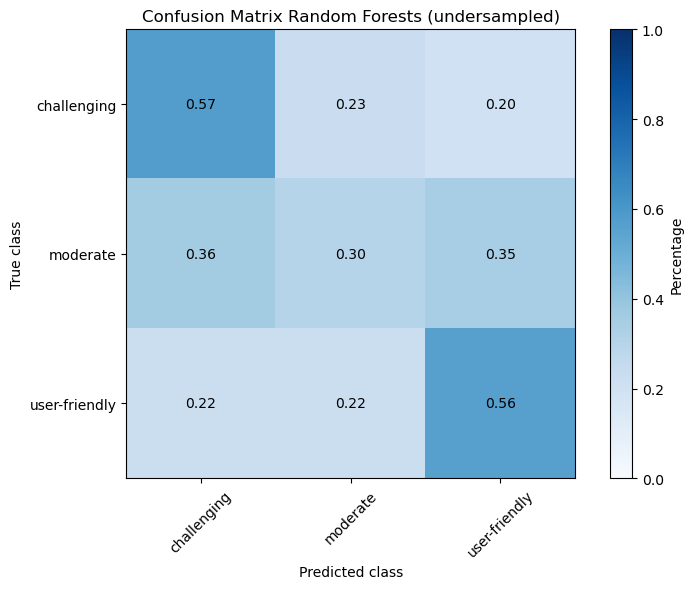

In [1131]:
# Evaluation
rf_mae = mean_absolute_error(y_test, y_pred)
print(f'Test MAE: {rf_mae:.3f}')
rf_mse = mean_squared_error(y_test, y_pred)
rf_rmse = rf_mse ** 0.5
print(f'Test RMSE: {rf_rmse:.3f}')
rf_kappa = cohen_kappa_score(y_test, y_pred, weights='quadratic')
print(f'Test CWK: {rf_kappa:.3f}')
print ()

# Confusion matrix
class_labels = {1: 'challenging', 2: 'moderate', 3: 'user-friendly'}
conf_matrix = confusion_matrix(y_test, y_pred)
conf_matrix_percent = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix_percent, cmap=plt.cm.Blues, vmin=0, vmax=1)
plt.title('Confusion Matrix Random Forests (undersampled)')
plt.colorbar(label='Percentage')
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, f'{conf_matrix_percent[i, j]:.2f}', ha='center', va='center', color='black')

plt.xlabel('Predicted class')
plt.ylabel('True class')
plt.xticks(np.arange(len(class_labels)), [class_labels[i] for i in sorted(class_labels)], rotation=45)
plt.yticks(np.arange(len(class_labels)), [class_labels[i] for i in sorted(class_labels)])

plt.tight_layout()
# plt.savefig('RFconfusion_matrix_baseline.png')
plt.show()

## LightGBM

In [60]:
# Baseline LightGBM with undersampling
lgbm_under = lgb.LGBMClassifier(objective='multiclass', num_class=3, verbose=-1, random_state=42)
lgbm_under.fit(X_train, y_train)
y_pred = lgbm_under.predict(X_test)

Test MAE: 0.640
Test RMSE: 0.982
Test CWK: 0.307


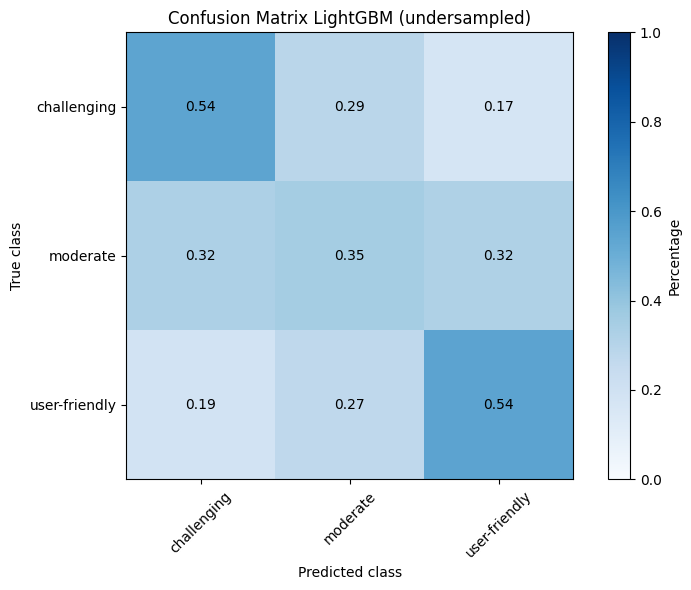

In [34]:
# Evaluation
lgbm_mae = mean_absolute_error(y_test, y_pred)
print(f'Test MAE: {lgbm_mae:.3f}')
lgbm_mse = mean_squared_error(y_test, y_pred)
lgbm_rmse = lgbm_mse ** 0.5
print(f'Test RMSE: {lgbm_rmse:.3f}')
lgbm_kappa = cohen_kappa_score(y_test, y_pred, weights='quadratic')
print(f'Test CWK: {lgbm_kappa:.3f}')

# Confusion matrix
class_labels = {1: 'challenging', 2: 'moderate', 3: 'user-friendly'}
conf_matrix = confusion_matrix(y_test, y_pred)
conf_matrix_percent = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix_percent, cmap=plt.cm.Blues, vmin=0, vmax=1)
plt.title('Confusion Matrix LightGBM (undersampled)')
plt.colorbar(label='Percentage')
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, f'{conf_matrix_percent[i, j]:.2f}', ha='center', va='center', color='black')

plt.xlabel('Predicted class')
plt.ylabel('True class')
plt.xticks(np.arange(len(class_labels)), [class_labels[i] for i in sorted(class_labels)], rotation=45)
plt.yticks(np.arange(len(class_labels)), [class_labels[i] for i in sorted(class_labels)])
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/3_classes/confusion_matrix_underdata.png')
plt.show()

## SVC 

In [226]:
# Perform scaling voor SVM, run for SVM
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [626]:
# Baseline SVC with undersampling 
start_time = time.time()

svc_under = SVC(kernel='rbf', decision_function_shape='ovr', random_state = 42, verbose = 0)
svc_under.fit(X_train, y_train)
y_pred = svc_under.predict(X_test)

end_time = time.time()
elapsed_time = end_time - start_time
hours, remainder = divmod(elapsed_time, 3600)
minutes, seconds = divmod(remainder, 60)
print(f"Execution time: {int(hours)} hours, {int(minutes)} minutes, {int(seconds)} seconds")

Execution time: 0 hours, 9 minutes, 28 seconds


Test MAE: 0.645
Test RMSE: 0.984
Test CWK: 0.303


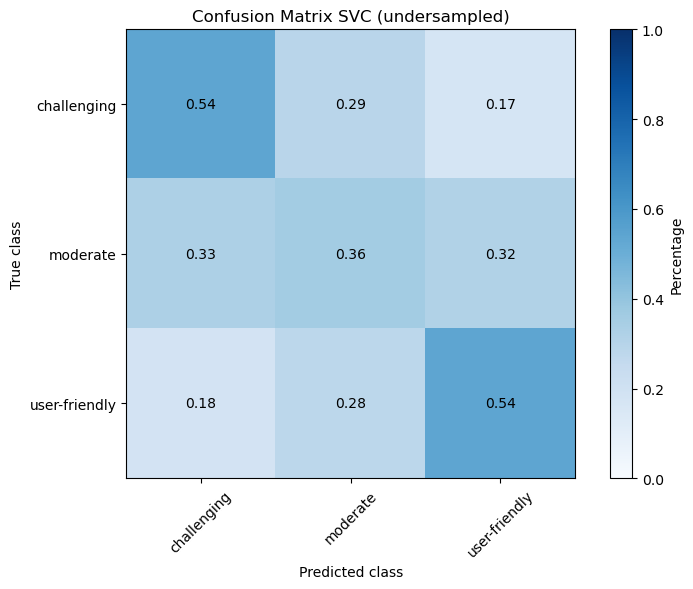

In [627]:
# Evaluation
svc_mae = mean_absolute_error(y_test, y_pred)
print(f'Test MAE: {svc_mae:.3f}')
svc_mse = mean_squared_error(y_test, y_pred)
svc_rmse = svc_mse ** 0.5
print(f'Test RMSE: {svc_rmse:.3f}')
svc_kappa = cohen_kappa_score(y_test, y_pred, weights='quadratic')
print(f'Test CWK: {svc_kappa:.3f}')

# Confusion matrix
class_labels = {1: 'challenging', 2: 'moderate', 3: 'user-friendly'}
conf_matrix = confusion_matrix(y_test, y_pred)
conf_matrix_percent = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix_percent, cmap=plt.cm.Blues, vmin=0, vmax=1)
plt.title('Confusion Matrix SVC (undersampled)')
plt.colorbar(label='Percentage')
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, f'{conf_matrix_percent[i, j]:.2f}', ha='center', va='center', color='black')
plt.xlabel('Predicted class')
plt.ylabel('True class')
plt.xticks(np.arange(len(class_labels)), [class_labels[i] for i in sorted(class_labels)], rotation=45)
plt.yticks(np.arange(len(class_labels)), [class_labels[i] for i in sorted(class_labels)])
plt.tight_layout()
plt.savefig('confusion_matrix_undersampledSVC.png')
plt.show()